# Import libraries and file paths

In [ ]:
!pip install tensorflow==2.15.0 -q
!pip install tensorflow-text==2.15.0 -q
!pip install transformers==4.37.2 -q

In [ ]:
# Standard libraries
import os
import json
from datetime import datetime

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Machine learning and deep learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# TensorFlow and Keras
import tensorflow as tf
import tensorflow_text as tf_text  # This registers TensorFlow ops.
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional,
    Embedding, Concatenate, Lambda, LayerNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# TensorFlow Hub for loading models
import tensorflow_hub as hub

# HuggingFace's Transformers
from transformers import (
    DistilBertTokenizer, TFDistilBertModel, DistilBertConfig,
    TFDistilBertForSequenceClassification
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Additional utilities
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# General path
project_file_path = '/content/drive/MyDrive/Colab Notebooks/FYP'

# Datasets preparation

In [ ]:
# Paths to dataset files
dataset_1_file_path = os.path.join(project_file_path, "GPT-wiki-intro-reformat-100000.csv")
test_essay_file_path = os.path.join(project_file_path, "test.csv")


In [ ]:
# Loading datasets into pandas DataFrames
dataset_1 = pd.read_csv(dataset_1_file_path)
test_essay = pd.read_csv(test_essay_file_path)

In [ ]:
# Renaming columns for consistency across datasets
# This helps in unifying column names for easier manipulation and understanding
dataset_1.rename(columns={'wiki_intro': 'text', 'generated_intro': 'generated'}, inplace=True)
test_essay.rename(columns={'article': 'text', 'class': 'generated'}, inplace=True)

In [ ]:
# Keeping only the relevant columns (text and generated labels)
dataset_1 = dataset_1[['text','generated']]

In [ ]:
train_data=dataset_1

In [ ]:
# Removing duplicate entries to ensure the uniqueness of data
# This helps in preventing bias towards repeated entries during training
train_data.drop_duplicates(inplace=True,ignore_index=True)
train_data

,text,generated
0,Sexhow railway station was a railway station b...,0
1,"In Finnish folklore, all places and things, an...",0
2,"In mathematics, specifically differential calc...",0
3,is a Japanese shōjo manga series written and i...,0
4,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0
...,...,...
99994,Let Loose is the debut album by American singe...,1
99995,"In Christianity, the word of wisdom is a colle...",1
99996,"David Anthony Willis, known professionally as ...",1
99997,Crispian Mills (born 18 January 1973 as Crispi...,1


generated
0    50000
1    49999
Name: count, dtype: int64


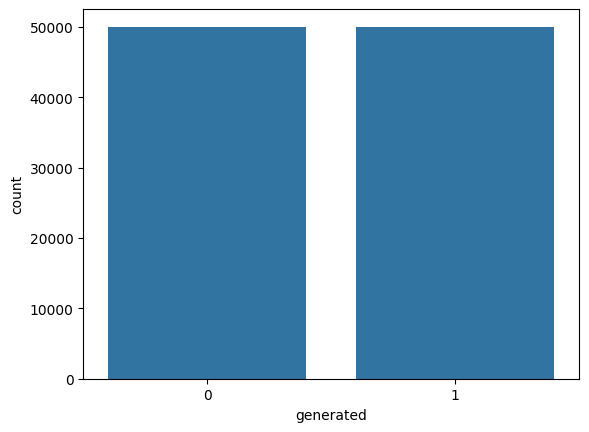

In [ ]:
# Displaying the balance of labels within the dataset
# It's important to check this to identify if there's an imbalance that needs addressing
train_data['generated'].value_counts()
print(train_data['generated'].value_counts())
sns.countplot(data=train_data, x='generated')
plt.show()

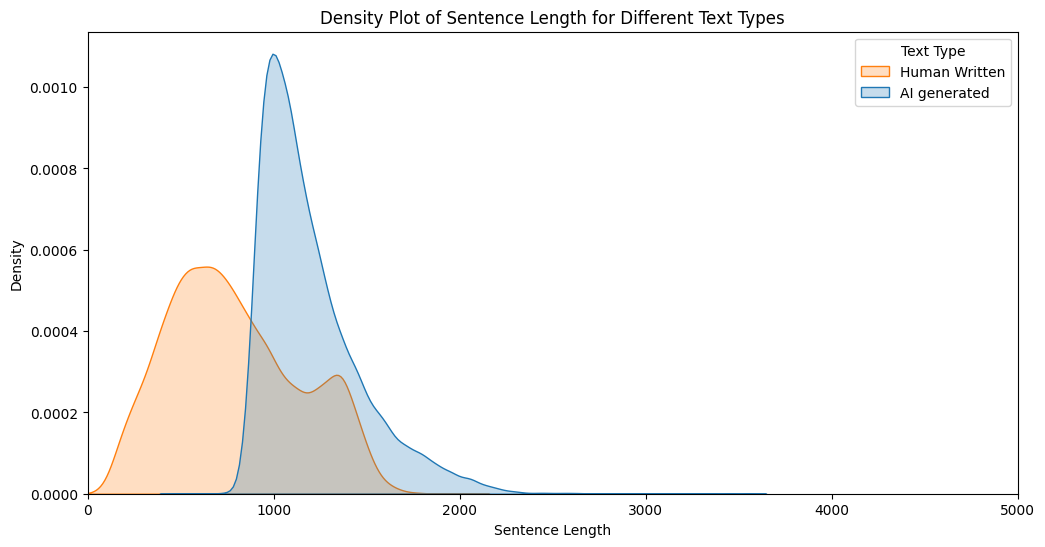

In [ ]:
# Adding a new column to represent the length of each sentence
# This is useful for understanding the distribution of text lengths in the dataset
train_data['sentence_length'] = train_data['text'].apply(len)

# Plotting the density of sentence lengths for both human-written and AI-generated texts
# This visualization aids in identifying differences in text length distributions between classes
plt.figure(figsize=(12, 6))
sns.kdeplot(data=dataset_1, x='sentence_length', hue='generated', fill=True)
plt.title('Density Plot of Sentence Length for Different Text Types')
plt.xlabel('Sentence Length')
plt.ylabel('Density')
plt.legend(title='Text Type', labels=['Human Written', 'AI generated'])
plt.xlim(0, 5000)  # Adjust this as needed to fit your data
plt.show()

In [ ]:
# Function to balance the number of labels in the dataset
# Balancing is crucial to avoid model bias towards the more frequent class
def balance_labels(train_data, label_column='generated'):
    label_counts=train_data[label_column].value_counts()
    max_count=label_counts.max()
    balanced_train_data=pd.DataFrame()

    for label, count in label_counts.items():
        label_subset = train_data[train_data[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_train_data = pd.concat([balanced_train_data, label_subset, oversampled_subset], ignore_index=True)

    return balanced_train_data

In [ ]:
# Applying the label balancing function to the training data
Train_Data=balance_labels(train_data)

In [ ]:
data_texts = Train_Data['text']
data_generated = Train_Data['generated']

In [ ]:
# Splitting the balanced dataset into training and testing sets
# This division is essential for training and evaluating the model's performance on unseen data
x_train,x_test,y_train,y_test=train_test_split(Train_Data.text,Train_Data.generated,test_size=0.2,shuffle=True, random_state=42)

# Outputting the shapes of the data splits to verify their sizes
# It's good practice to check the sizes to ensure data has been split as expected
print("Training set size:", x_train.shape)
print("Test set size:", x_test.shape)
print("Training labels size:", y_train.shape)
print("Test labels size:", y_test.shape)

Training set size: (80000,)
Test set size: (20000,)
Training labels size: (80000,)
Test labels size: (20000,)


# F1 Class Function

In [ ]:
class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='f1_score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    # Initialize Precision and Recall metrics which will be used to calculate F1 Score
    self.precision = tf.keras.metrics.Precision()
    self.recall = tf.keras.metrics.Recall()

  def get_config(self):
    # Necessary for model serialization: returns the config of the metric
    base_config = super(F1Score, self).get_config()
    return {**base_config}

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Update the state of Precision and Recall with the current batch of data
    self.precision.update_state(y_true, y_pred, sample_weight=sample_weight)
    self.recall.update_state(y_true, y_pred, sample_weight=sample_weight)

  def result(self):
    # Calculate and return the F1 Score using the current state of Precision and Recall
    p = self.precision.result()
    r = self.recall.result()
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))


  def reset_state(self):
    # Reset the state of the Precision and Recall metrics
    self.precision.reset_state()
    self.recall.reset_state()

#Model configuration

In [ ]:
# Function to recursively convert numpy arrays to lists for JSON serialization
def convert_to_list(obj):
  if isinstance(obj, np.ndarray):
    # Convert numpy array to list
    return obj.tolist()
  elif isinstance(obj, dict):
    # Recursively apply conversion for dictionaries
    return {key: convert_to_list(value) for key, value in obj.items()}
  elif isinstance(obj, list):
    # Recursively apply conversion for lists
    return [convert_to_list(item) for item in obj]
  else:
    # Return the object as is if it's neither an array, list, nor dictionary
    return obj

In [ ]:
# Function to print model evaluation metrics
def print_evaluation_metrics(results, metric_names, prefix=''):
  for value, name in zip(results, metric_names):
      # Check if the metric value is a scalar or an array
    if isinstance(value, np.ndarray):
      # Convert array values to string for printing
      value_str = ", ".join([str(v) for v in value])
      print(f"{prefix} {name}: [{value_str}]")
    else:
      # Print the scalar value with formatting
      print(f"{prefix} {name}: {value:.3f}")


In [ ]:
# URLs for the BERT preprocessor and encoder, facilitating the use of BERT models from TensorFlow Hub
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2"

# Learning rate and batch size for all the model training process
learning_rate = 1e-5
batch_size=16

# Paths for saving the trained model and metrics
# It includes learning rate and batch size in the filename for easier identification
model_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/bert-model-saved_v3'
model_weights_filename = f'model_weights_lr{learning_rate}_bs{batch_size}_0.01.h5'
model_weights_path = os.path.join(model_save_path, model_weights_filename)

metrics_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/bert-model-metrics_v3'
metrics_weights_filename = f"model_metrics_lr{learning_rate}_bs{batch_size}_0.01.json"

# Paths for saving the training history and evaluation results, incorporating learning rate and batch size
history_path = os.path.join(metrics_save_path, f"training_history_lr{learning_rate}_bs{batch_size}_0.01.json")
eval_results_path = os.path.join(metrics_save_path, f"evaluation_results_lr{learning_rate}_bs{batch_size}_0.01.json")

# BERT Model

In [ ]:
def build_bert_model(preprocessor_url, encoder_url, trainable=True):
  # Define the input layer that accepts text strings
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  # Load the BERT preprocessor from TensorFlow Hub
  preprocessor = hub.KerasLayer(preprocessor_url)
  # Preprocess text input for BERT
  encoder_inputs = preprocessor(text_input)

  # Load the BERT encoder from TensorFlow Hub
  encoder = hub.KerasLayer(encoder_url, trainable=trainable)
    # Get BERT's output
  outputs = encoder(encoder_inputs)
  pooled_output = outputs['pooled_output']
  sequence_output = outputs["sequence_output"]

  # Add custom layers on top of BERT's output
  lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))(sequence_output)
  # Concatenate LSTM output with BERT's pooled output
  concatenated = Concatenate()([lstm_layer, pooled_output])
  # Additional dropout and dense layers for classification
  dropout_layer = tf.keras.layers.Dropout(0.5, name="dropout_1")(concatenated)
  dense_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)
  dropout_layer2 = tf.keras.layers.Dropout(0.3 , name="dropout_2")(dense_layer)
  # Final output layer for binary classification
  output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer2)

  # Create and return the model
  model = tf.keras.Model(inputs=text_input, outputs=output_layer)
  return model



In [ ]:
# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(metrics_save_path, exist_ok=True)

# Instantiate the model with the specified BERT preprocessor and encoder
model_bert = build_bert_model(preprocessor_url, encoder_url)

# Load model weights if they exist, indicating a previously trained model
if os.path.exists(model_weights_path):
    print(f"Loading the saved model weights from: {model_weights_path}")
    # Compile the model with optimizer, loss, and metrics
    model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=["accuracy", Precision(), Recall(), F1Score()])
    # Load the saved weights
    model_bert.load_weights(model_weights_path)

    # Load training history if it exists
    if os.path.exists(history_path):
      with open(history_path, "r") as f:
        history_dict = json.load(f)
        print("Training history loaded!")

else:
    # If model weights do not exist, build a new model
    model_bert = build_bert_model(preprocessor_url, encoder_url)
    print("Building new model.")

    # Compile the model
    model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                      loss='binary_crossentropy',
                      metrics=["accuracy", Precision(), Recall(), F1Score()])

    # Define callbacks for checkpointing and early stopping
    checkpoint_callback = ModelCheckpoint(filepath=model_weights_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max')

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


    # Convert labels to float32 for compatibility with model expectations
    y_train = tf.cast(y_train, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    # Train the model with the training set, and validate with the test set
    history = model_bert.fit(x_train, y_train,
                            batch_size,
                            epochs=2,
                            validation_data=(x_test, y_test),
                            callbacks=[checkpoint_callback, early_stopping_callback])

    # Save the training history for future reference
    history_dict_converted = convert_to_list(history.history)
    # history_path = os.path.join(metrics_save_path, f"training_history_lr{learning_rate}_bs{batch_size}_0.001.json")
    with open(history_path, "w") as f:
        json.dump(history_dict_converted, f)

    # Save the entire model for future loading
    model_bert.save(model_save_path)
print(model_bert.summary())

Loading the saved model weights from: /content/drive/MyDrive/Colab Notebooks/FYP/bert-model-saved_v3/model_weights_lr1e-05_bs16_0.01.h5
Training history loaded!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              

In [ ]:
# Check if the evaluation results file already exists
if os.path.exists(eval_results_path):
    # Load and display the evaluation results if available
    with open(eval_results_path, "r") as f:
        eval_results = json.load(f)
    print("Evaluation Results Loaded Successfully:")
    print(json.dumps(eval_results, indent=4))
else:
    # If evaluation results do not exist, perform evaluation on the training and test sets
    results_train = model_bert.evaluate(x_train, y_train)
    results_test = model_bert.evaluate(x_test, y_test)

    # Print the evaluation metrics using a predefined function
    metric_names = model_bert.metrics_names
    print_evaluation_metrics(results_train, metric_names, "Model BERT Train Metrics:")
    print_evaluation_metrics(results_test, metric_names, "\nModel BERT Test Metrics:")

    # Prepare the evaluation results for serialization
    eval_results = {
        "train": {metric: value for metric, value in zip(metric_names, results_train)},
        "test": {metric: value for metric, value in zip(metric_names, results_test)}
    }

    # Convert evaluation results to a serializable format
    eval_results_serializable = convert_to_list(eval_results)

    # Save the serializable evaluation results to a JSON file
    with open(eval_results_path, "w") as f:
        json.dump(eval_results_serializable, f)

    print(f"Training and evaluation metrics saved at: {metrics_save_path}")


Evaluation Results Loaded Successfully:
{
    "train": {
        "loss": 0.31690821051597595,
        "accuracy": 0.9621750116348267,
        "precision_4": 0.9297475814819336,
        "recall_4": 0.9999750256538391,
        "f1_score": 0.9635833501815796
    },
    "test": {
        "loss": 0.42490723729133606,
        "accuracy": 0.9462500214576721,
        "precision_4": 0.9029187560081482,
        "recall_4": 0.9995986223220825,
        "f1_score": 0.9488021731376648
    }
}


## BERT graphs

In [ ]:
# Use the trained BERT model to predict the classes of texts in `test_essay`
y_pred_prob = model_bert.predict(test_essay['text'])

# Convert prediction probabilities to binary labels based on a specified threshold
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# Extract the true labels from the test dataset for comparison
y_true = test_essay['generated'].values

# Generate a confusion matrix to compare the true and predicted labels
conf_mat = confusion_matrix(y_true, y_pred.flatten())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT with LSTM Confusion Matrix ')
plt.show()

1/1 [==============================] - 6s 6s/step


KeyError: 'generated'

In [ ]:
# Calculate the ROC curve and AUC for model evaluation
y_scores = y_pred_prob.flatten() # Ensure prediction probabilities are in a 1D array
# Generate ROC curve values: FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall, precision, lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

In [ ]:
# Visualize model accuracy and loss over training epochs
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train')
plt.plot(history_dict['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train')
plt.plot(history_dict['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Additional plot for cross-entropy loss, if desired for more detailed analysis
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# BERT no LSTM model

In [ ]:
# Paths for saving the trained model and metrics
# It includes learning rate and batch size in the filename for easier identification
model_BERT_noLSTM_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/bert_model_noLSTM_v2'
model_weights_BERT_noLSTM_filename = f'model_weights_lr{learning_rate}_bs{batch_size}.h5'  # Include lr and batch size in the filename
model_BERT_noLSTM_weights_path = os.path.join(model_BERT_noLSTM_save_path, model_weights_BERT_noLSTM_filename)

metrics_BERT_noLSTM_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/bert_model_metrics_noLSTM_v2'
metrics_weights_filename = f"model_metrics_lr{learning_rate}_bs{batch_size}_0.01.json"

# Paths for saving the training history and evaluation results, incorporating learning rate and batch size
history_path_BERT_noLSTM = os.path.join(metrics_BERT_noLSTM_save_path, f"training_history_lr{learning_rate}_bs{batch_size}_0.01.json")
eval_results_path_BERT_noLSTM = os.path.join(metrics_BERT_noLSTM_save_path, f"evaluation_results_lr{learning_rate}_bs{batch_size}_0.01.json")

In [ ]:
def build_bert_model_without_lstm(preprocessor_url, encoder_url, trainable=True):
      # Define the input layer that accepts text strings
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    # Load the BERT preprocessor from TensorFlow Hub
    preprocessor = hub.KerasLayer(preprocessor_url)
    # Preprocess text input for BERT
    encoder_inputs  = preprocessor(text_input)

    # Load the BERT encoder from TensorFlow Hub
    encoder = hub.KerasLayer(encoder_url,trainable=True)
    # Get BERT's output
    outputs = encoder(encoder_inputs)
    pooled_output = outputs['pooled_output'] # [batch_size, 512].
    sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 512].

    # Dropout and dense layers for classification
    dropout_layer1 = tf.keras.layers.Dropout(0.5, name="dropout1")(pooled_output)
    dense = tf.keras.layers.Dense(64 , activation='relu', kernel_regularizer=l2(0.01), name="dense")(dropout_layer1)
    dropout_layer2 = tf.keras.layers.Dropout(0.3 , name="dropout2")(dense)

    # Final output layer for binary classification
    output_layer = tf.keras.layers.Dense(1 , activation='sigmoid', kernel_regularizer=l2(0.01), name='output')(dropout_layer2)

    # Create and return the model
    model = tf.keras.Model(inputs=text_input, outputs=output_layer)
    return model

In [ ]:
# Ensure directories exist
os.makedirs(model_BERT_noLSTM_save_path, exist_ok=True)
os.makedirs(metrics_BERT_noLSTM_save_path, exist_ok=True)


# Instantiate the model with the specified BERT preprocessor and encoder
model_bert_noLSTM = build_bert_model_without_lstm(preprocessor_url, encoder_url)

# Compile the model
model_bert_noLSTM.compile(optimizer=Adam(learning_rate),
                                loss='binary_crossentropy',
                                metrics=["accuracy", Precision(), Recall(), F1Score()])


# Load model if weights exist, else build a new model
if os.path.exists(model_BERT_noLSTM_weights_path):
    print(f"Loading the saved model weights from: {model_BERT_noLSTM_weights_path}")
    # Compile the model with optimizer, loss, and metrics
    model_bert_noLSTM.load_weights(model_BERT_noLSTM_weights_path)

    # Load the saved weights
    if os.path.exists(history_path_BERT_noLSTM):
      with open(history_path_BERT_noLSTM, "r") as f:
        history_dict_BERT_noLSTM = json.load(f)
        print("Training history loaded!")
else:
    print("Building new model.")
    # If model weights do not exist, build a new model
    model_bert_noLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                      loss='binary_crossentropy',
                      metrics=["accuracy", Precision(), Recall(), F1Score()])

    # Define callbacks for checkpointing and early stopping
    checkpoint_callback = ModelCheckpoint(filepath=model_BERT_noLSTM_weights_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max')

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


    # Convert labels to float32 for compatibility with model expectations
    y_train = tf.cast(y_train, tf.float32)
    y_test = tf.cast(y_test, tf.float32)


    # Train the model with the training set, and validate with the test set
    history_without_lstm = model_bert_noLSTM.fit(x_train, y_train,
                            batch_size,
                            epochs=2,
                            validation_data=(x_test, y_test),
                            callbacks=[checkpoint_callback, early_stopping_callback])


    # Save the training history for future reference
    history_dict_converted = convert_to_list(history_without_lstm.history)
    with open(history_path_BERT_noLSTM, "w") as f:
        json.dump(history_dict_converted, f)


    # Save the entire model for future loading
    model_bert_noLSTM.save(model_BERT_noLSTM_save_path)
print(model_bert_noLSTM.summary())

Loading the saved model weights from: /content/drive/MyDrive/Colab Notebooks/FYP/bert_model_noLSTM_v2/model_weights_lr1e-05_bs16.h5
Training history loaded!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'inp

In [ ]:
# Check if the evaluation results file already exists
if os.path.exists(eval_results_path_BERT_noLSTM):
    # Load and display the evaluation results if available
    with open(eval_results_path_BERT_noLSTM, "r") as f:
        eval_results_noLSTM = json.load(f)
    print("Evaluation Results Loaded Successfully:")
    print(json.dumps(eval_results_noLSTM, indent=4))
else:
    # If evaluation results do not exist, perform evaluation on the training and test sets
    results_train = model_bert_noLSTM.evaluate(x_train, y_train)
    results_test = model_bert_noLSTM.evaluate(x_test, y_test)

    # Print the evaluation metrics using a predefined function
    metric_names = model_bert_noLSTM.metrics_names
    print_evaluation_metrics(results_train, metric_names, "Model BERT Train Metrics:")
    print_evaluation_metrics(results_test, metric_names, "\nModel BERT Test Metrics:")

    # Prepare the evaluation results for serialization
    eval_results_noLSTM = {
        "train": {metric: value for metric, value in zip(metric_names, results_train)},
        "test": {metric: value for metric, value in zip(metric_names, results_test)}
    }

    # Convert evaluation results to a serializable format
    eval_results_serializable = convert_to_list(eval_results_noLSTM)

    # Save the serializable evaluation results to a JSON file
    with open(eval_results_path_BERT_noLSTM, "w") as f:
        json.dump(eval_results_serializable, f)

    print(f"Training and evaluation metrics saved at: {metrics_BERT_noLSTM_save_path}")

Evaluation Results Loaded Successfully:
{
    "train": {
        "loss": 0.29824382066726685,
        "accuracy": 0.9652000069618225,
        "precision_14": 0.9350430965423584,
        "recall_14": 0.9999250769615173,
        "f1_score": 0.9663962125778198
    },
    "test": {
        "loss": 0.37687715888023376,
        "accuracy": 0.9491999745368958,
        "precision_14": 0.9079223275184631,
        "recall_14": 0.999397873878479,
        "f1_score": 0.9514663815498352
    }
}


## Bert no LSTM model - Graphs

32/32 [==============================] - 6s 143ms/step


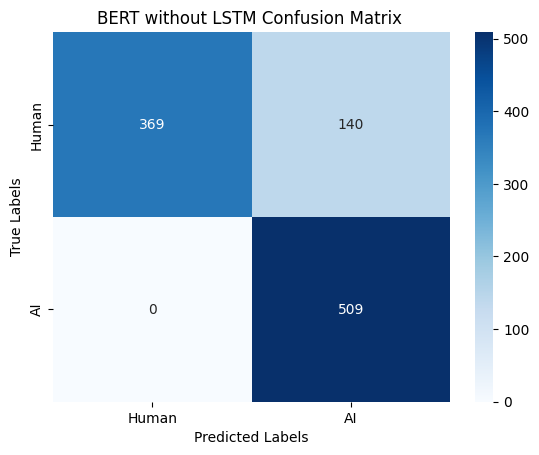

In [ ]:
# Use the trained BERT model to predict the classes of texts in `test_essay`
y_pred_prob_b_noLSTM = model_bert_noLSTM.predict(test_essay['text'])

# Convert prediction probabilities to binary labels based on a specified threshold
threshold = 0.5
y_pred_b_noLSTM = (y_pred_prob_b_noLSTM > threshold).astype(int)

# Extract the true labels from the test dataset for comparison
y_true_b_noLSTM = test_essay['generated'].values

# Generate a confusion matrix to compare the true and predicted labels
conf_mat = confusion_matrix(y_true_b_noLSTM, y_pred_b_noLSTM.flatten())  # Flatten y_pred if it's not already 1D
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT without LSTM Confusion Matrix ')
plt.show()

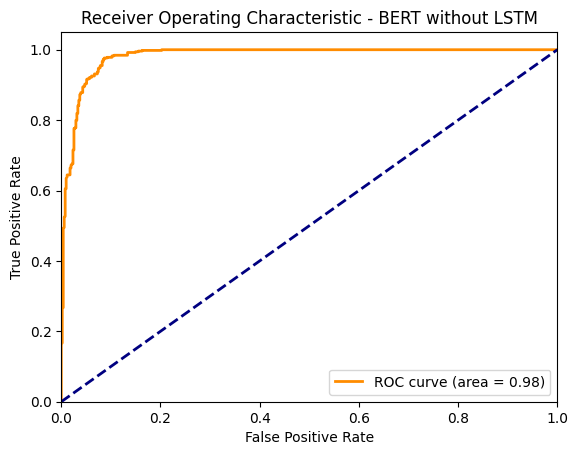

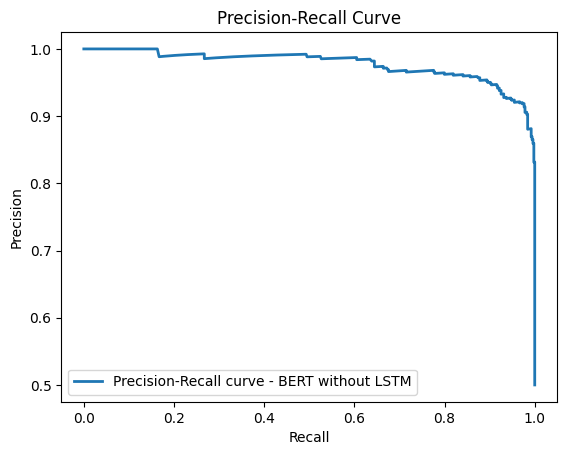

In [ ]:
# Calculate the ROC curve and AUC for model evaluation
y_scores_b_noLSTM = y_pred_prob_b_noLSTM.flatten()  # Ensure y_scores is a 1D array if it isn't already
# Generate ROC curve values: FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_true_b_noLSTM, y_scores_b_noLSTM)
# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - BERT without LSTM')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true_b_noLSTM, y_scores_b_noLSTM)
plt.figure()
plt.plot(recall, precision, lw=2, label='Precision-Recall curve - BERT without LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

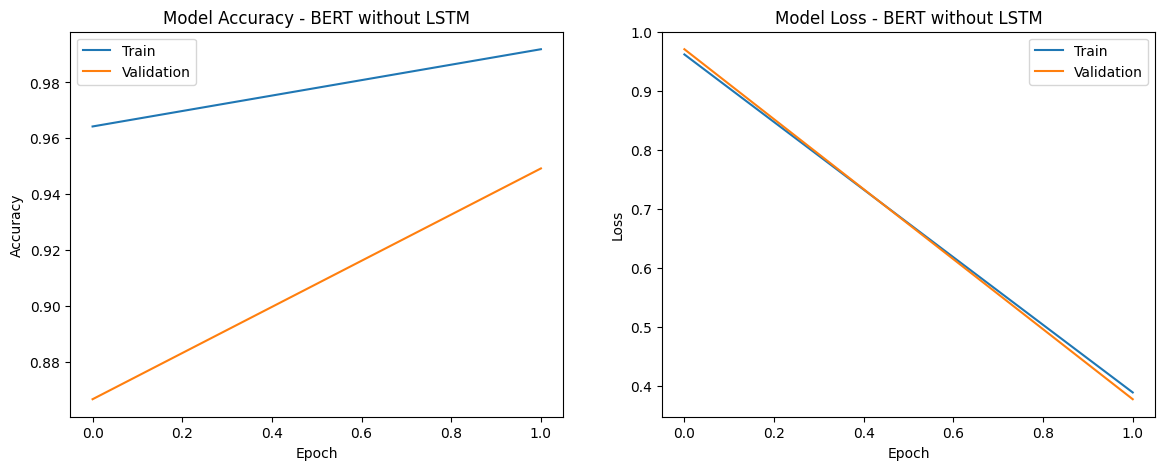

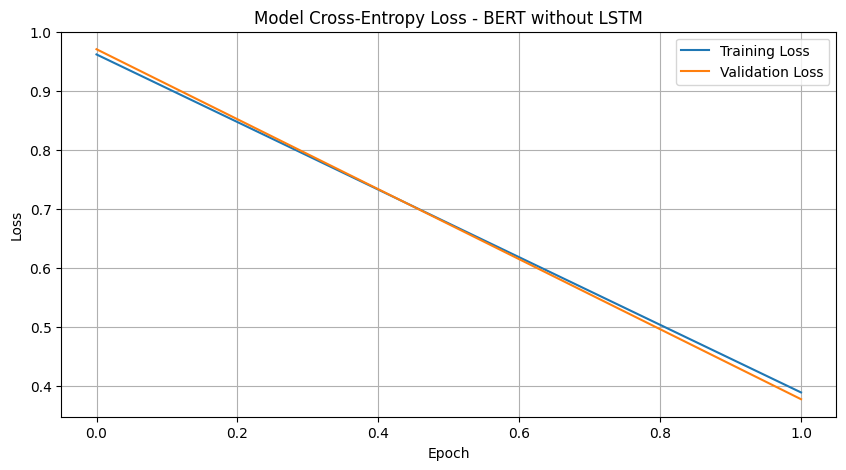

In [ ]:
# Visualize model accuracy and loss over training epochs
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict_BERT_noLSTM['accuracy'], label='Train')
plt.plot(history_dict_BERT_noLSTM['val_accuracy'], label='Validation')
plt.title('Model Accuracy - BERT without LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict_BERT_noLSTM['loss'], label='Train')
plt.plot(history_dict_BERT_noLSTM['val_loss'], label='Validation')
plt.title('Model Loss - BERT without LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Additional plot for cross-entropy loss, if desired for more detailed analysis
plt.figure(figsize=(10, 5))
plt.plot(history_dict_BERT_noLSTM['loss'], label='Training Loss')
plt.plot(history_dict_BERT_noLSTM['val_loss'], label='Validation Loss')
plt.title('Model Cross-Entropy Loss - BERT without LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.show()

# DistilBERT Model


In [ ]:
# This sets the maximum sequence length for a given operation or model.
max_seq_length = 512

# Paths for saving the trained model and metrics
# It includes learning rate and batch size in the filename for easier identification
model_distilBERT_save_path = "/content/drive/MyDrive/Colab Notebooks/FYP/distilbert_saved_model_v2"
model_weights_DistilBERT_filename = f'model_weights_lr{learning_rate}_bs{batch_size}'
model_distilBERT_weights_path = os.path.join(model_distilBERT_save_path, model_weights_DistilBERT_filename)


metrics_distilBERT_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/distilbert_model_metrics_v2'
metrics_distilBERT_weights_filename = f"model_metrics_lr{learning_rate}_bs{batch_size}_0.01.json"

# Paths for saving the training history and evaluation results, incorporating learning rate and batch size
history_path_dB = os.path.join(metrics_distilBERT_save_path, f"training_history_lr{learning_rate}_bs{batch_size}_0.01.json")
eval_results_path_dB = os.path.join(metrics_distilBERT_save_path, f"evaluation_results_lr{learning_rate}_bs{batch_size}_0.01.json")

In [ ]:
def create_distilbert_model(max_seq_length):
    # Define input layers for DistilBERT (input IDs and attention masks)
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")

    # Initialize the configuration for DistilBERT
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
    distilBERT = TFDistilBertModel(config)

    # Get the sequence output from DistilBERT model
    distilbert_output = distilBERT(input_ids=input_ids, attention_mask=attention_masks)
    sequence_output = distilbert_output.last_hidden_state

    # Extract the first token's embeddings to mimic the pooled output of BERT
    clf_output = Lambda(lambda seq: seq[:, 0, :])(sequence_output)

    # Add an LSTM layer to further process the sequence output from DistilBERT
    lstm_layer = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))(sequence_output)

    # Concatenate the output of LSTM layer and the first token embeddings
    concatenated = Concatenate()([lstm_layer, clf_output])

    # Add dropout for regularization
    dropout_layer1 = Dropout(0.5)(concatenated)
    # Dense layer for further learning
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer1)
    # Another dropout layer for regularization
    dropout_layer2 = Dropout(0.3)(dense_layer)
    # Output layer with sigmoid activation for binary classification
    output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

    # Define the model with its inputs and output
    model = Model(inputs=[input_ids, attention_masks], outputs=output_layer)
    return model

# Initialize the tokenizer for DistilBERT
tokenizer_distilBERT = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(texts, tokenizer, max_length = max_seq_length):
    # Initialize dictionaries to hold the input IDs and attention masks
    encodings = {'input_ids': [], 'attention_mask': []}
    # Iterate through each item in the text list
    for text in tqdm(texts, desc="Tokenizing data"):
        # Tokenize the current text, ensuring it is truncated and padded to `max_length`
        # This returns tensors in TensorFlow format (`return_tensors="tf"`)
        tokens = tokenizer(text, truncation=True, padding="max_length", max_length=max_length, return_tensors="tf")
        # Append the input IDs and attention masks to their respective lists, squeezing to remove unnecessary dimensions
        encodings['input_ids'].append(tokens['input_ids'].numpy().squeeze())
        encodings['attention_mask'].append(tokens['attention_mask'].numpy().squeeze())
    # Convert the lists of input IDs and attention masks into numpy arrays for easier handling in batches
    encodings['input_ids'] = np.stack(encodings['input_ids'])
    encodings['attention_mask'] = np.stack(encodings['attention_mask'])
    # Return the prepared encodings
    return encodings

In [ ]:
# Convert the 'text' and 'generated' columns into lists
data_texts_db = Train_Data['text'].tolist()
data_labels_db = Train_Data['generated'].tolist()

# Split the dataset into training and testing sets with a test size of 20%.
# The `random_state` ensures reproducibility of the splits.
x_train_db, x_test_db, y_train_db, y_test_db = train_test_split(data_texts_db, data_labels_db, test_size=0.2, random_state=42)

# Tokenize the training and testing data.
# This converts the texts into a format suitable for input into DistilBERT,
# including padding or truncating to a maximum sequence length and converting to tensors.
train_encodings_db = tokenize_data(x_train_db, tokenizer_distilBERT, max_seq_length)
test_encodings_db = tokenize_data(x_test_db, tokenizer_distilBERT, max_seq_length)

# Convert the labels into TensorFlow tensors with a float32 datatype.
# This step is necessary for compatibility with TensorFlow's loss functions and model expectations.
y_train_db = tf.convert_to_tensor(y_train_db, dtype=tf.float32)
y_test_db = tf.convert_to_tensor(y_test_db, dtype=tf.float32)

# Preparing TensorFlow datasets from the tokenized data and labels, batching them.
# `from_tensor_slices` creates a tf.data.Dataset object suitable for training.
# The dataset is batched with a specified `batch_size` to allow for mini-batch gradient descent during training.
train_dataset_db = tf.data.Dataset.from_tensor_slices(({"input_ids": train_encodings_db['input_ids'], "attention_mask": train_encodings_db['attention_mask']}, y_train_db)).batch(batch_size)
test_dataset_db = tf.data.Dataset.from_tensor_slices(({"input_ids": test_encodings_db['input_ids'], "attention_mask": test_encodings_db['attention_mask']}, y_test_db)).batch(batch_size)


Tokenizing data:   0%|          | 0/80000 [00:00<?, ?it/s]

Tokenizing data:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Ensure the directories for saving the model and metrics exist
os.makedirs(model_distilBERT_save_path, exist_ok=True)
os.makedirs(metrics_distilBERT_save_path, exist_ok=True)

# Initialize the model
model_distilBERT = create_distilbert_model(max_seq_length)

# Compile the model with the specified optimizer, loss function, and metrics
model_distilBERT.compile(optimizer=Adam(learning_rate),
                          loss='binary_crossentropy',
                          metrics=["accuracy", Precision(), Recall(), F1Score()])

# Check if model weights already exist to load them
if os.path.exists(model_distilBERT_weights_path):
    print(f"Loading the saved model weights from: {model_distilBERT_weights_path}")
    model_distilBERT.load_weights(model_distilBERT_weights_path)

    # Load training history if it exists
    if os.path.exists(history_path_dB):
      with open(history_path_dB, "r") as f:
        history_dict_dB = json.load(f)
        print("Training history loaded!")
else:
    print("Building new model.")
    model_distilBERT = create_distilbert_model(max_seq_length)
    model_distilBERT.compile(optimizer=Adam(learning_rate),
                             loss='binary_crossentropy',
                             metrics=["accuracy", Precision(), Recall(), F1Score()])

    # Callback to save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(filepath=model_distilBERT_weights_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max')
    # Callback to stop training early if validation loss doesn't improve
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


    #Train the model
    history_db = model_distilBERT.fit(train_dataset_db,
                                   validation_data=test_dataset_db,
                                   epochs=2,
                                   callbacks=[checkpoint_callback, early_stopping_callback])

    # Convert the training history into a list format to ensure JSON serializability
    # Assuming `convert_to_list` is a function you've defined to convert the history object
    history_dict_converted_dB = convert_to_list(history_db.history)

    # Save the training history
    with open(history_path_dB, "w") as f:
        json.dump(history_dict_converted_dB, f)

    # Save the entire model after training
    model_distilBERT.save(model_distilBERT_save_path)

# Print the model summary to get an overview of the model's architecture
print(model_distilBERT.summary())

Loading the saved model weights from: /content/drive/MyDrive/Colab Notebooks/FYP/distilbert_saved_model_v2/model_weights_lr1e-05_bs16
Training history loaded!
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den

In [ ]:
# Check if the evaluation results already exist
if os.path.exists(eval_results_path_dB):
    # If evaluation results exist, load them
    with open(eval_results_path_dB, "r") as f:
        eval_results_dB = json.load(f)
    print("Evaluation Results Loaded Successfully:")
    # Print the loaded evaluation results
    print(json.dumps(eval_results_dB, indent=4))
else:
    # If evaluation results do not exist, evaluate the model on the training and test datasets
    results_train_db = model_distilBERT.evaluate(train_dataset_db)
    results_test_db = model_distilBERT.evaluate(test_dataset_db)

    # Print the evaluation metrics for both training and test datasets
    # Note: The `print_evaluation_metrics` function should be defined to format and print the evaluation results.
    # It is assumed to take the evaluation results, the metric names, and a title for the output.
    metric_names = model_distilBERT.metrics_names
    print_evaluation_metrics(results_train_db, metric_names, "Model BERT Train Metrics:")
    print_evaluation_metrics(results_test_db, metric_names, "\nModel BERT Test Metrics:")

    # Organize the evaluation results in a dictionary for easy JSON serialization
    eval_results_dB = {
        "train": {metric: value for metric, value in zip(metric_names, results_train_db)},
        "test": {metric: value for metric, value in zip(metric_names, results_test_db)}
    }

    # Convert the evaluation results to a format that can be serialized to JSON
    # The `convert_to_list` function should correctly handle converting numpy data types to native Python types for JSON serialization.
    # This function needs to be defined elsewhere in your code.
    eval_results_serializable_dB = convert_to_list(eval_results_dB)

    # Save the evaluation results to a JSON file for future reference
    with open(eval_results_path_dB, "w") as f:
        json.dump(eval_results_serializable_dB, f)

    print(f"Training and evaluation metrics saved at: {metrics_distilBERT_save_path}")

Evaluation Results Loaded Successfully:
{
    "train": {
        "loss": 0.4010995924472809,
        "accuracy": 0.9861124753952026,
        "precision_32": 0.9935835599899292,
        "recall_32": 0.9785687327384949,
        "f1_score": 0.98601895570755
    },
    "test": {
        "loss": 0.46666356921195984,
        "accuracy": 0.9613500237464905,
        "precision_32": 0.9811557531356812,
        "recall_32": 0.9404917359352112,
        "f1_score": 0.9603934288024902
    }
}


In [ ]:
# Tokenize the test essays
# This function converts the essays into a format that the model can understand,
# including converting sentences into sequences of token ids and creating attention masks.
test_essay_encodings_db = tokenize_data(test_essay['text'].tolist(), tokenizer_distilBERT, max_seq_length)

# Convert the tokenized data into a TensorFlow dataset.
# The dataset is structured to include the necessary inputs for the model: 'input_ids' and 'attention_mask'.
# 'input_ids' are the tokenized representations of the essays, and 'attention_mask' indicates to the model which parts of the input are actual data versus padding.
# The `.batch(batch_size)` method groups these inputs into batches, making it easier to process large amounts of data efficiently during prediction.
test_essay_dataset_db = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_essay_encodings_db['input_ids'], "attention_mask": test_essay_encodings_db['attention_mask']}
)).batch(batch_size)

Tokenizing data:   0%|          | 0/1018 [00:00<?, ?it/s]

## DistilBERT Model - Graphs

64/64 [==============================] - 9s 108ms/step


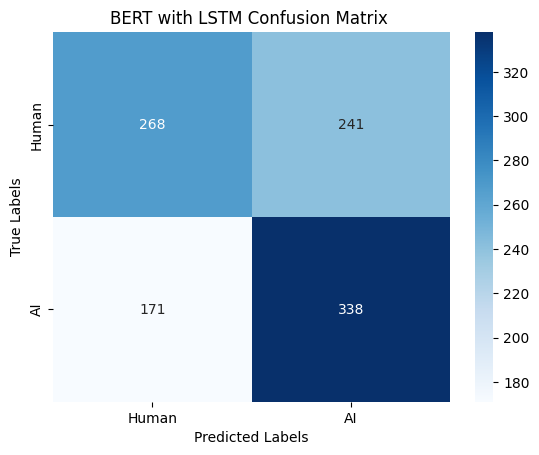

In [ ]:
# Directly predicting probabilities of the 'generated' class (e.g., AI-written) from the processed test essays
y_pred_prob_db = model_distilBERT.predict(test_essay_dataset_db)

# Convert probabilities to binary labels based on a defined threshold (0.5 in this case)
# The assumption here is that the model outputs a probability of belonging to the positive class.
# If the probability is greater than 0.5, the prediction is considered as 1 (AI-written); otherwise, it's 0 (Human-written).
threshold = 0.5
y_pred_db = (y_pred_prob_db > threshold).astype(int)

# Extract the true labels from the test dataset for comparison
# It's assumed that `test_essay` DataFrame has a 'generated' column which contains the true labels.
y_true_db = test_essay['generated'].values

# Now, `y_pred_db` and `y_true_db` are both arrays of binary values and can be directly compared.
# Compute the confusion matrix to evaluate how well the predictions match the true labels.
conf_mat = confusion_matrix(y_true_db, y_pred_db.flatten())
# Plot the confusion matrix using seaborn for better visualization.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DistilBERT with LSTM Confusion Matrix ')
plt.show()
# plt.savefig(f"matrix_{current_date}")

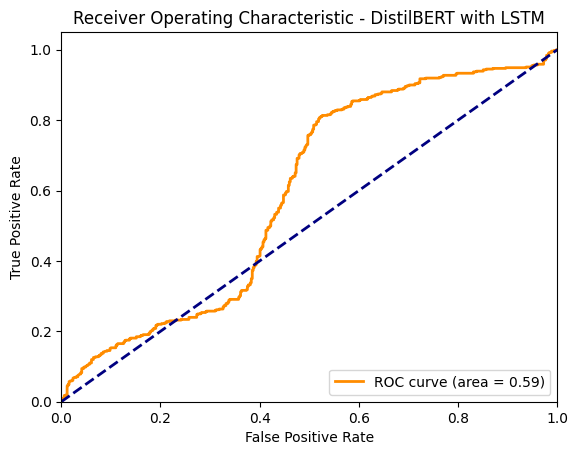

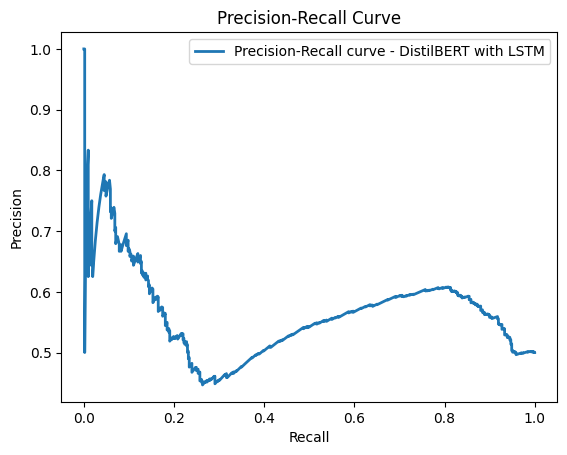

In [ ]:
# Flatten the predicted probabilities to a 1D array for compatibility with roc_curve and precision_recall_curve functions.
y_scores_db = y_pred_prob_db.flatten()
# Generate ROC curve values: false positive rates (FPR), true positive rates (TPR), and thresholds.
# The roc_curve function computes the TPR and FPR for various threshold values, allowing us to plot the ROC curve.
fpr, tpr, thresholds = roc_curve(y_true_db, y_scores_db)

# Calculate the Area Under the Curve (AUC) for the ROC curve.
# The AUC represents the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - DistilBERT with LSTM')
plt.legend(loc="lower right")
plt.show()

# Generate Precision-Recall curve values: precision, recall, and thresholds.
# Unlike the ROC curve, the Precision-Recall curve focuses on the performance of the classifier on the positive (minority) class.
precision, recall, _ = precision_recall_curve(y_true_db, y_scores_db)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, lw=2, label='Precision-Recall curve - DistilBERT with LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

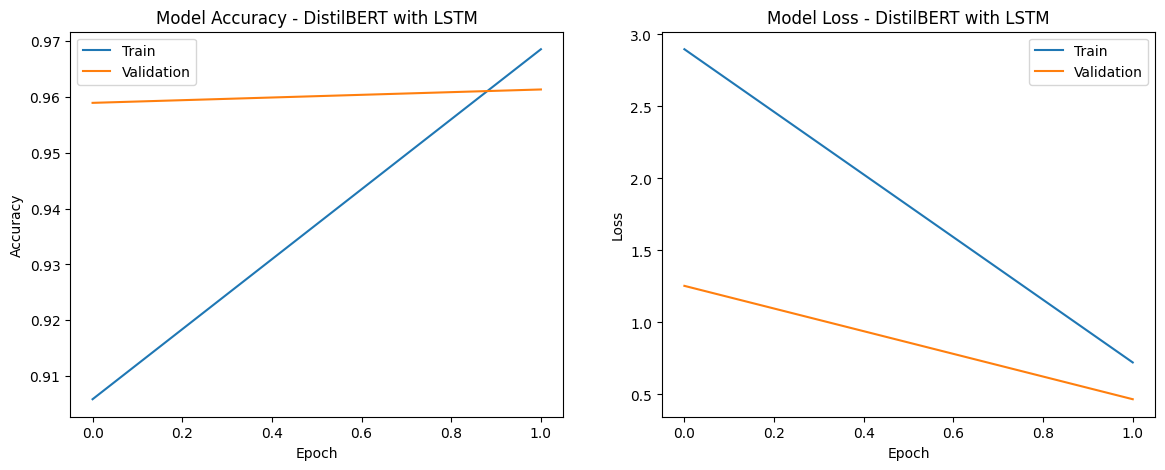

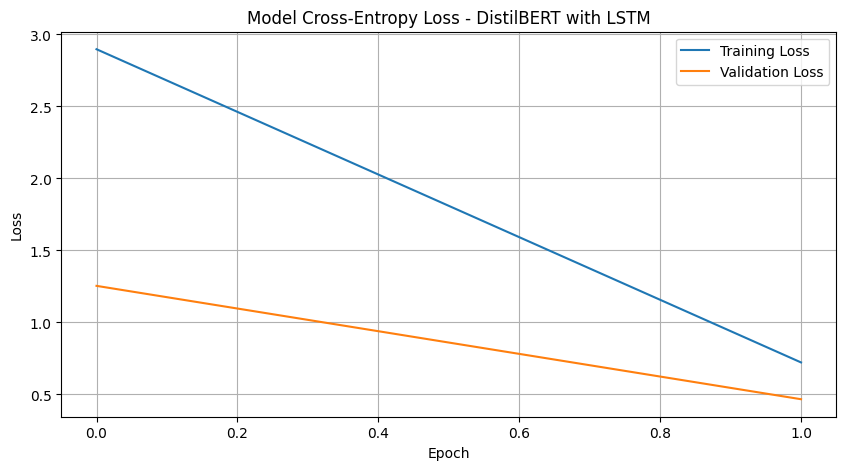

In [ ]:
# Set up a figure for plotting model accuracy and loss side by side.
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict_dB['accuracy'], label='Train')
plt.plot(history_dict_dB['val_accuracy'], label='Validation')
plt.title('Model Accuracy - DistilBERT with LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss in the second subplot area
plt.subplot(1, 2, 2)
plt.plot(history_dict_dB['loss'], label='Train')
plt.plot(history_dict_dB['val_loss'], label='Validation')
plt.title('Model Loss - DistilBERT with LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Cross-Entropy Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history_dict_dB['loss'], label='Training Loss')
plt.plot(history_dict_dB['val_loss'], label='Validation Loss')
plt.title('Model Cross-Entropy Loss - DistilBERT with LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.show()

# DistilBERT no LSTM model

In [ ]:
# This sets the maximum sequence length for a given operation or model.
max_seq_length = 512
# Paths for saving the trained model and metrics
model_distilBERT_noLSTM_save_path = "/content/drive/MyDrive/Colab Notebooks/FYP/distilbert_noLSTM_model_saved_v3"
model_weights_DistilBERT_noLSTM_filename = f'model_weights_lr{learning_rate}_bs{batch_size}'
model_distilBERT_noLSTM_weights_path = os.path.join(model_distilBERT_noLSTM_save_path, model_weights_DistilBERT_noLSTM_filename)

metrics_distilBERT_noLSTM_save_path = '/content/drive/MyDrive/Colab Notebooks/FYP/distilbert_noLSTM_model_metrics_v3'
metrics_distilBERT_noLSTM_weights_filename = f"model_metrics_lr{learning_rate}_bs{batch_size}_0.01.json"

# It includes learning rate and batch size in the filename for easier identification
# Paths for saving the training history and evaluation results, incorporating learning rate and batch size
history_path_dB_noLSTM = os.path.join(metrics_distilBERT_noLSTM_save_path, f"training_history_lr{learning_rate}_bs{batch_size}_0.01.json")
eval_results_path_dB_noLSTM = os.path.join(metrics_distilBERT_noLSTM_save_path, f"evaluation_results_lr{learning_rate}_bs{batch_size}_0.01.json")




In [ ]:
def tokenize_data(texts, tokenizer, max_length = max_seq_length):
    # Initialize dictionaries to hold the input IDs and attention masks
    encodings = {'input_ids': [], 'attention_mask': []}
    # Iterate through each item in the text list
    for text in tqdm(texts, desc="Tokenizing data"):
        # Tokenize the current text, ensuring it is truncated and padded to `max_length`
        # This returns tensors in TensorFlow format (`return_tensors="tf"`)
        tokens = tokenizer(text, truncation=True, padding="max_length", max_length=max_length, return_tensors="tf")
        # Append the input IDs and attention masks to their respective lists, squeezing to remove unnecessary dimensions
        encodings['input_ids'].append(tokens['input_ids'].numpy().squeeze())
        encodings['attention_mask'].append(tokens['attention_mask'].numpy().squeeze())
    # Convert the lists of input IDs and attention masks into numpy arrays for easier handling in batches
    encodings['input_ids'] = np.stack(encodings['input_ids'])
    encodings['attention_mask'] = np.stack(encodings['attention_mask'])
    # Return the prepared encodings
    return encodings

In [ ]:
def create_distilbert_noLSTM_model(max_seq_length):
    # Define input layers for DistilBERT (input IDs and attention masks)
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")

    # Initialize the configuration for DistilBERT
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
    # Load DistilBERT model with the specified config
    distilBERT = TFDistilBertModel(config)

    # Get the sequence output from DistilBERT model
    distilbert_output = distilBERT(input_ids=input_ids, attention_mask=attention_masks)
    sequence_output = distilbert_output.last_hidden_state

    # Extract the first token's embeddings to mimic the pooled output of BERT
    clf_output = Lambda(lambda seq: seq[:, 0, :])(sequence_output)

    # Add dropout for regularization
    dropout_layer = Dropout(0.5)(clf_output)
    # Dense layer for further learning
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)
    # Another dropout layer for regularization
    dropout_layer2 = Dropout(0.3)(dense_layer)
    # Output layer with sigmoid activation for binary classification
    output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

    # Define the model with its inputs and output
    model = Model(inputs=[input_ids, attention_masks], outputs=output_layer)
    return model

# Initialize the tokenizer for DistilBERT
tokenizer_distilBERT_noLSTM = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Convert the 'text' and 'generated' columns into lists
data_texts_db_noLSTM = Train_Data['text'].tolist()
data_labels_db_noLSTM = Train_Data['generated'].tolist()

# Split the dataset into training and testing sets with a test size of 20%.
# The `random_state` ensures reproducibility of the splits.
x_train_db_noLSTM, x_test_db_noLSTM, y_train_db_noLSTM, y_test_db_noLSTM = train_test_split(data_texts_db_noLSTM, data_labels_db_noLSTM, test_size=0.2, random_state=42)

# Tokenize the training and testing data.
# This converts the texts into a format suitable for input into DistilBERT,
# including padding or truncating to a maximum sequence length and converting to tensors.
train_encodings_db_noLSTM = tokenize_data(x_train_db_noLSTM, tokenizer_distilBERT_noLSTM, max_seq_length)
test_encodings_db_noLSTM = tokenize_data(x_test_db_noLSTM, tokenizer_distilBERT_noLSTM, max_seq_length)

# Convert the labels into TensorFlow tensors with a float32 datatype.
# This step is necessary for compatibility with TensorFlow's loss functions and model expectations.
y_train_db_noLSTM = tf.convert_to_tensor(y_train_db_noLSTM, dtype=tf.float32)
y_test_db_noLSTM = tf.convert_to_tensor(y_test_db_noLSTM, dtype=tf.float32)

# Preparing TensorFlow datasets from the tokenized data and labels, batching them.
# `from_tensor_slices` creates a tf.data.Dataset object suitable for training.
# The dataset is batched with a specified `batch_size` to allow for mini-batch gradient descent during training.
train_dataset_db_noLSTM = tf.data.Dataset.from_tensor_slices(({"input_ids": train_encodings_db_noLSTM['input_ids'], "attention_mask": train_encodings_db_noLSTM['attention_mask']}, y_train_db_noLSTM)).batch(batch_size)
test_dataset_db_noLSTM = tf.data.Dataset.from_tensor_slices(({"input_ids": test_encodings_db_noLSTM['input_ids'], "attention_mask": test_encodings_db_noLSTM['attention_mask']}, y_test_db_noLSTM)).batch(batch_size)


Tokenizing data:   0%|          | 0/80000 [00:00<?, ?it/s]

Tokenizing data:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# Ensure the directories for saving the model and metrics exist
os.makedirs(model_distilBERT_noLSTM_save_path, exist_ok=True)
os.makedirs(metrics_distilBERT_noLSTM_save_path, exist_ok=True)

# Initialize the model
model_distilBERT_noLSTM = create_distilbert_noLSTM_model(max_seq_length)

# Compile the model with the specified optimizer, loss function, and metrics
model_distilBERT_noLSTM.compile(optimizer=Adam(learning_rate),
                          loss='binary_crossentropy',
                          metrics=["accuracy", Precision(), Recall(), F1Score()])

# Check if model weights already exist to load them
if os.path.exists(model_distilBERT_noLSTM_weights_path):
    print(f"Loading the saved model weights from: {model_distilBERT_noLSTM_weights_path}")
    model_distilBERT_noLSTM.load_weights(model_distilBERT_noLSTM_weights_path)

    # Load training history if it exists
    if os.path.exists(history_path_dB_noLSTM):
      with open(history_path_dB_noLSTM, "r") as f:
        history_dict_dB_noLSTM = json.load(f)
        print("Training history loaded!")
else:
    print("Building new model.")
    model_distilBERT_noLSTM = create_distilbert_noLSTM_model(max_seq_length)
    model_distilBERT_noLSTM.compile(optimizer=Adam(learning_rate),
                             loss='binary_crossentropy',
                             metrics=["accuracy", Precision(), Recall(), F1Score()])

    # Callback to save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(filepath=model_distilBERT_noLSTM_weights_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max')
    # Callback to stop training early if validation loss doesn't improve
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    #Train the model
    history_db_noLSTM = model_distilBERT_noLSTM.fit(train_dataset_db_noLSTM,
                                   validation_data=test_dataset_db_noLSTM,
                                   epochs=2,
                                   callbacks=[checkpoint_callback, early_stopping_callback])

    # Convert the training history into a list format to ensure JSON serializability
    # Assuming `convert_to_list` is a function you've defined to convert the history object
    history_dict_converted_dB_noLSTM = convert_to_list(history_db_noLSTM.history)
    try:
    # Save the training history
      with open(history_path_dB_noLSTM, "w") as f:
        json.dump(history_dict_converted_dB_noLSTM, f)
        print(f"Training history saved at: {history_path_dB_noLSTM}")
    except Exception as e:
      print(f"Error saving training history: {e}")

    # Save the entire model after training
    model_distilBERT_noLSTM.save(model_distilBERT_noLSTM_save_path)

# Print the model summary to get an overview of the model's architecture
print(model_distilBERT_noLSTM.summary())

Loading the saved model weights from: /content/drive/MyDrive/Colab Notebooks/FYP/distilbert_noLSTM_model_saved_v3/model_weights_lr1e-05_bs16
Training history loaded!
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)        

In [ ]:
# Check if evaluation results already exist
if os.path.exists(eval_results_path_dB_noLSTM):
    # If evaluation results exist, load them
    with open(eval_results_path_dB_noLSTM, "r") as f:
        eval_results_dB_noLSTM = json.load(f)
    print("Evaluation Results Loaded Successfully:")
    # Print the loaded evaluation results
    print(json.dumps(eval_results_dB_noLSTM, indent=4))
else:
    # If evaluation results do not exist, evaluate the model on the training and test datasets
    results_train_db_noLSTM = model_distilBERT_noLSTM.evaluate(train_dataset_db_noLSTM)
    results_test_db_noLSTM = model_distilBERT_noLSTM.evaluate(test_dataset_db_noLSTM)

    # Print the evaluation metrics for both training and test datasets
    # Note: The `print_evaluation_metrics` function should be defined to format and print the evaluation results.
    # It is assumed to take the evaluation results, the metric names, and a title for the output.
    metric_names = model_distilBERT_noLSTM.metrics_names
    print_evaluation_metrics(results_train_db_noLSTM, metric_names, "Model BERT Train Metrics:")
    print_evaluation_metrics(results_test_db_noLSTM, metric_names, "\nModel BERT Test Metrics:")

    # Organize the evaluation results in a dictionary for easy JSON serialization
    eval_results_dB_noLSTM = {
        "train": {metric: value for metric, value in zip(metric_names, results_train_db_noLSTM)},
        "test": {metric: value for metric, value in zip(metric_names, results_test_db_noLSTM)}
    }

    # Convert the evaluation results to a format that can be serialized to JSON
    # The `convert_to_list` function should correctly handle converting numpy data types to native Python types for JSON serialization.
    # This function needs to be defined elsewhere in your code.
    eval_results_serializable_dB_noLSTM = convert_to_list(eval_results_dB_noLSTM)

    # Save the evaluation results to a JSON file for future reference
    with open(eval_results_path_dB_noLSTM, "w") as f:
        json.dump(eval_results_serializable_dB_noLSTM, f)

    print(f"Training and evaluation metrics saved at: {metrics_distilBERT_noLSTM_save_path}")

Evaluation Results Loaded Successfully:
{
    "train": {
        "loss": 0.3567199110984802,
        "accuracy": 0.9876999855041504,
        "precision_8": 0.9890545010566711,
        "recall_8": 0.9863369464874268,
        "f1_score": 0.9876938462257385
    },
    "test": {
        "loss": 0.4157969653606415,
        "accuracy": 0.9649999737739563,
        "precision_8": 0.9731385707855225,
        "recall_8": 0.9561465382575989,
        "f1_score": 0.9645677208900452
    }
}


In [ ]:
# Tokenize the test essays
# This function converts the essays into a format that the model can understand,
# including converting sentences into sequences of token ids and creating attention masks.
test_essay_encodings_db_noLSTM = tokenize_data(test_essay['text'].tolist(), tokenizer_distilBERT_noLSTM, max_seq_length)

# Convert the tokenized data into a TensorFlow dataset.
# The dataset is structured to include the necessary inputs for the model: 'input_ids' and 'attention_mask'.
# 'input_ids' are the tokenized representations of the essays, and 'attention_mask' indicates to the model which parts of the input are actual data versus padding.
# The `.batch(batch_size)` method groups these inputs into batches, making it easier to process large amounts of data efficiently during prediction.
test_essay_dataset_db_noLSTM = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_essay_encodings_db_noLSTM['input_ids'], "attention_mask": test_essay_encodings_db_noLSTM['attention_mask']}
)).batch(batch_size)

Tokenizing data:   0%|          | 0/1018 [00:00<?, ?it/s]

## DistilBERT no LSTM Model - Graphs

32/32 [==============================] - 7s 178ms/step


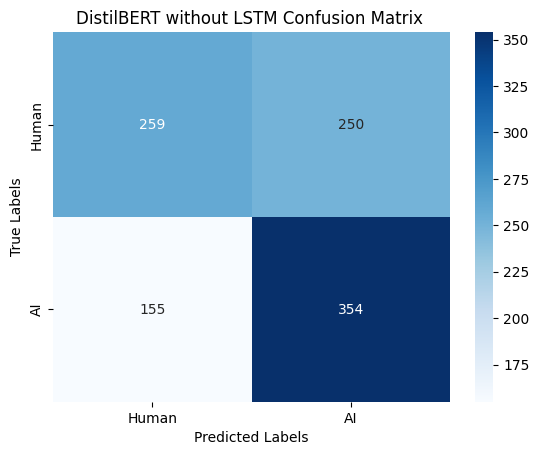

In [ ]:
# Directly predicting probabilities of the 'generated' class (e.g., AI-written) from the processed test essays
y_pred_prob_db_noLSTM = model_distilBERT_noLSTM.predict(test_essay_encodings_db_noLSTM)

# Convert probabilities to binary labels based on a defined threshold (0.5 in this case)
# The assumption here is that the model outputs a probability of belonging to the positive class.
# If the probability is greater than 0.5, the prediction is considered as 1 (AI-written); otherwise, it's 0 (Human-written).
threshold = 0.5
y_pred_db_noLSTM = (y_pred_prob_db_noLSTM > threshold).astype(int)

# Extract the true labels from the test dataset for comparison
# It's assumed that `test_essay` DataFrame has a 'generated' column which contains the true labels.
y_true_db_noLSTM = test_essay['generated'].values

# Now, `y_pred_db` and `y_true_db` are both arrays of binary values and can be directly compared.
# Compute the confusion matrix to evaluate how well the predictions match the true labels.
conf_mat = confusion_matrix(y_true_db_noLSTM, y_pred_db_noLSTM.flatten())
# Plot the confusion matrix using seaborn for better visualization.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DistilBERT without LSTM Confusion Matrix ')
plt.show()



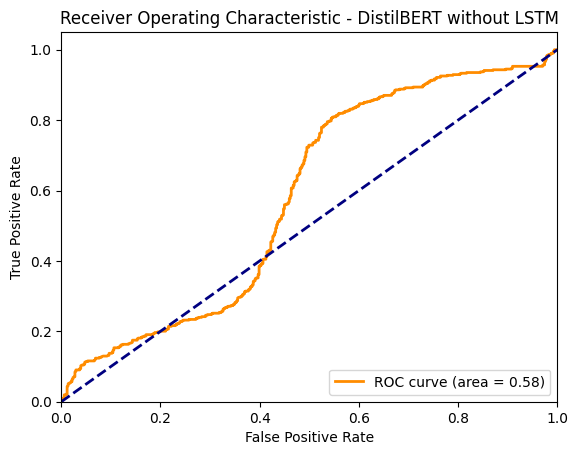

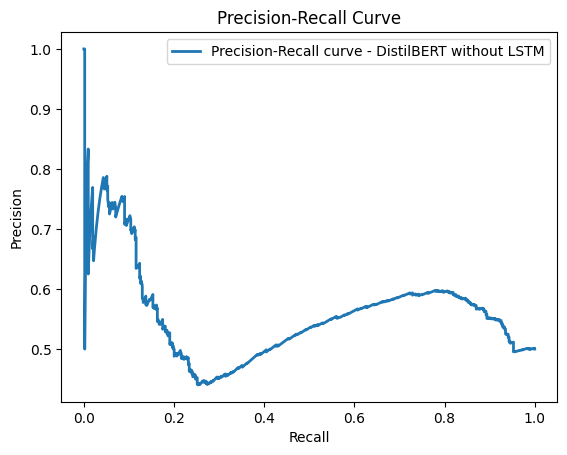

In [ ]:
# Flatten the predicted probabilities to a 1D array for compatibility with roc_curve and precision_recall_curve functions.
y_scores_db_noLSTM = y_pred_prob_db_noLSTM.flatten()
# Generate ROC curve values: false positive rates (FPR), true positive rates (TPR), and thresholds.
# The roc_curve function computes the TPR and FPR for various threshold values, allowing us to plot the ROC curve.
fpr, tpr, thresholds = roc_curve(y_true_db_noLSTM, y_scores_db_noLSTM)

# Calculate the Area Under the Curve (AUC) for the ROC curve.
# The AUC represents the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - DistilBERT without LSTM')
plt.legend(loc="lower right")
plt.show()

# Generate Precision-Recall curve values: precision, recall, and thresholds.
# Unlike the ROC curve, the Precision-Recall curve focuses on the performance of the classifier on the positive (minority) class.
precision, recall, _ = precision_recall_curve(y_true_db_noLSTM, y_scores_db_noLSTM)
# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, lw=2, label='Precision-Recall curve - DistilBERT without LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

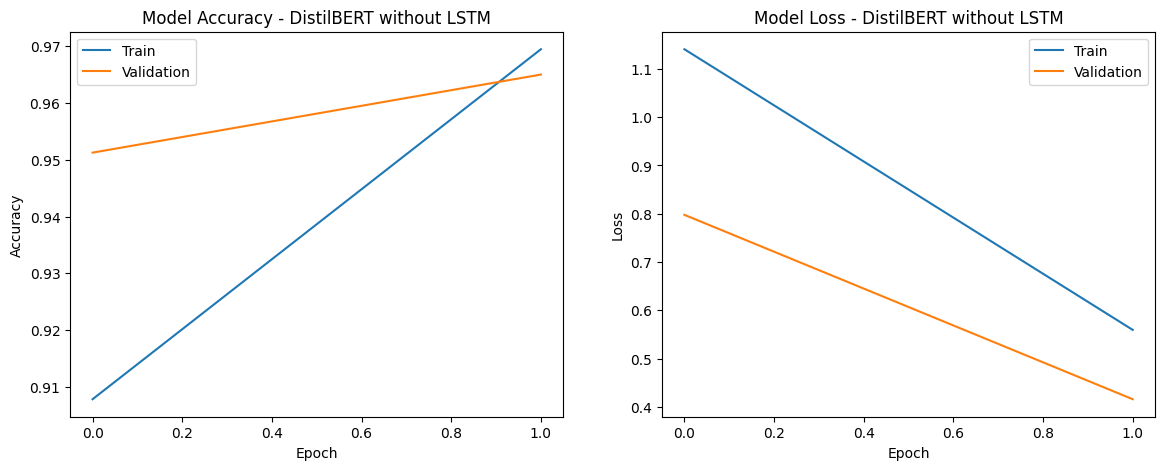

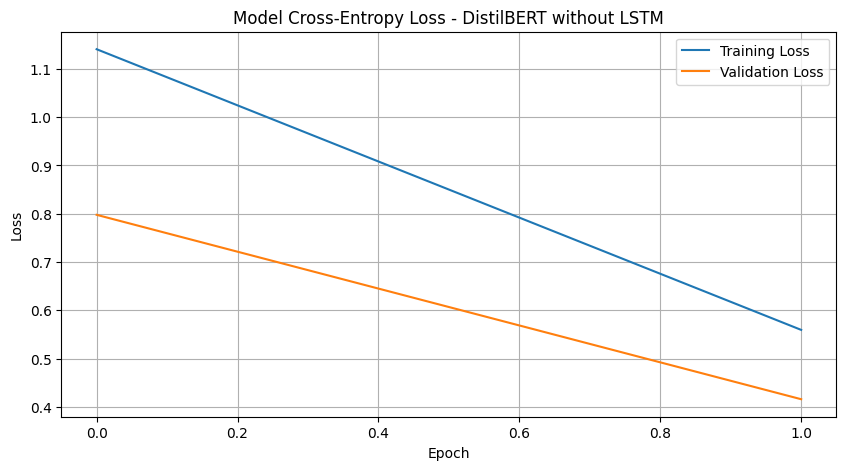

In [ ]:
# Set up a figure for plotting model accuracy and loss side by side.
plt.figure(figsize=(14, 5))
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict_dB_noLSTM['accuracy'], label='Train')
plt.plot(history_dict_dB_noLSTM['val_accuracy'], label='Validation')
plt.title('Model Accuracy - DistilBERT without LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss in the second subplot area
plt.subplot(1, 2, 2)
plt.plot(history_dict_dB_noLSTM['loss'], label='Train')
plt.plot(history_dict_dB_noLSTM['val_loss'], label='Validation')
plt.title('Model Loss - DistilBERT without LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Cross-Entropy Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history_dict_dB_noLSTM['loss'], label='Training Loss')
plt.plot(history_dict_dB_noLSTM['val_loss'], label='Validation Loss')
plt.title('Model Cross-Entropy Loss - DistilBERT without LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.show()

# Dataset Prediction


In [ ]:
# Prediction of the column [text] with the main model
y_pred = model_bert.predict(test_essay['text'])

1/1 [==============================] - 1s 1s/step


In [ ]:
# Create a DataFrame for submission. This includes the 'id' from `test_essay`,
# predictions from `y_pred` (assumed to be probabilities, hence taking the first column if multidimensional),
# and the 'text' of the essays.
submission_path = '/content/drive/MyDrive/Colab Notebooks/FYP/results/submissions'
# Define the path where the submission file will be saved. Make sure the path exists or handle appropriately.
submission = pd.DataFrame({'id': test_essay['id'], 'generated': y_pred[:,0], 'text': test_essay['text']})

# Create a filename with the current date
filename = os.path.join(submission_path, "submission.csv")

# Save the DataFrame to a CSV file. `index=False` is specified to avoid adding an unwanted column of indices.
submission.to_csv(filename, index=False)


# Steganography

In [ ]:
submission_file =  pd.read_csv(os.path.join(submission_path, "submission.csv"))
submission_file

,id,generated,text
0,0,0.097185,NLP is a multidisciplinary field that draws fr...


In [ ]:
def ascii_to_zwc(value):
    # Define a mapping from binary pairs to specific zero-width characters
    mapping = {
        '00': '\u200B',  # Zero Width Space
        '01': '\u200C',  # Zero Width Non-Joiner
        '10': '\u200D',  # Zero Width Joiner
        '11': '\u2060',  # Word Joiner
    }
    # Convert the input value to a 12-bit binary string.
    # The format string '012b' specifies zero-padding to 12 bits in binary representation.
    binary_string = format(value, f'012b')
    # Create the zero-width character sequence by mapping each 2-bit segment of the binary string
    # to its corresponding zero-width character as defined in the mapping.
    zwc_sequence = ''.join(mapping[binary_string[i:i+2]] for i in range(0, len(binary_string), 2))
    # Return the constructed sequence of zero-width characters.
    return zwc_sequence

In [ ]:
def encode_secret_message(text, secret_message):
    # Calculate the interval for inserting encoded characters based on the lengths
    # of the original text and the secret message.
    text_length = len(text)
    secret_message_length = len(secret_message)
    interval = text_length // secret_message_length
    encoded_message = ""

    # Encode each character of the secret message into zero-width characters.
    for char in secret_message:
        ascii_value = ord(char) # Convert character to ASCII value.
        transformed_value = ascii_value ^ 170 # Apply XOR operation for a simple obfuscation.
        zwc_sequence = ascii_to_zwc(transformed_value) # Encode the transformed value as ZWC sequence.
        encoded_message += zwc_sequence  # Append the ZWC sequence to the encoded message.

    watermarked_text = ""
    last_insert_position = 0
    # Insert the encoded message into the original text at calculated intervals.
    for i in range(secret_message_length):
        # Determine the position in the original text where the next piece of the encoded message will be inserted.
        insert_position = (i + 1) * interval if i < secret_message_length - 1 else text_length
        # Slice the encoded message for this interval.
        watermarked_text += text[last_insert_position:insert_position] + encoded_message[i * (len(encoded_message) // secret_message_length):(i + 1) * (len(encoded_message) // secret_message_length)]
        # Insert the slice of the encoded message into the original text.
        last_insert_position = insert_position

    # Append any remaining part of the original text.
    watermarked_text += text[last_insert_position:]
    return watermarked_text

In [ ]:
def zwc_to_ascii(zwc_sequence):
    # Define a mapping from zero-width characters back to their binary representations
    reverse_mapping = {
        '\u200B': '00', # Zero Width Space
        '\u200C': '01', # Zero Width Non-Joiner
        '\u200D': '10', # Zero Width Joiner
        '\u2060': '11', # Word Joiner
    }
    # Convert the sequence of zero-width characters into a binary string
    # by using the reverse mapping defined above.
    binary_string = ''.join(reverse_mapping[zwc] for zwc in zwc_sequence)
    # Convert the binary string back to its original ASCII value.
    # The `int` function with base 2 is used to convert from binary to decimal.
    return int(binary_string, 2)


In [ ]:
def decode_watermarked_text(watermarked_text, secret_message_length):
    # Define the set of valid zero-width characters used for encoding the message.
    valid_zwc_characters = {'\u200B', '\u200C', '\u200D', '\u2060'}
    # Filter out the watermarked text to retain only the zero-width characters.
    # This step is necessary because the watermarked text contains a mix of regular and zero-width characters.
    filtered_watermarked_text = ''.join(char for char in watermarked_text if char in valid_zwc_characters)

    # Initialize an empty string to hold the decoded message.
    decoded_message = ''

    # Iterate through the filtered text in chunks of 6 characters, assuming each original character was encoded into 6 ZWCs.
    for i in range(0, len(filtered_watermarked_text), 6):  # Assuming 6 ZWCs per original character
        # Extract a sequence of 6 ZWCs from the filtered text.
        zwc_sequence = filtered_watermarked_text[i:i + 6]
        # Ensure that the sequence contains only valid ZWCs.
        if all(zwc in valid_zwc_characters for zwc in zwc_sequence):
            # Convert the ZWC sequence back to its original ASCII value using the `zwc_to_ascii` function.
            ascii_value = zwc_to_ascii(zwc_sequence)
            # Perform the reverse XOR operation to obtain the original ASCII value.
            original_char = chr(ascii_value ^ 170)
            # Append the decoded character to the decoded message.
            decoded_message += original_char

    # Return the fully decoded message.
    return decoded_message

In [ ]:
def apply_encoding_based_on_generated(row):
  # Extract the text content from the row.
  text=row['text']
  # Determine the secret message based on the 'generated' field's value.
  secret_message = "Written by Human" if row['generated'] <= 0.5 else "AI generated"
  # Check if the text is long enough to encode the secret message.
  if len(text) < len(secret_message):
    # If the text is too short, return "NA".
    return "NA"
  else:
    # If the text is sufficiently long, encode the secret message into the text.
    return encode_secret_message(text, secret_message)

In [ ]:
def apply_decoding_on_generated(row):
    # Determine the secret message based on the 'generated' field's value.
    # This logic must match exactly with the logic used during encoding to ensure consistency.
    secret_message = "Written by Human" if row['generated'] <= 0.5 else "AI generated"
    # Calculate the length of the secret message.
    # This is needed because the decoding function requires the length of the message to correctly decode it.
    secret_message_length = len(secret_message)
    # Decode using the encoded text and the determined length
    return decode_watermarked_text(row['watermarked_text'], secret_message_length)

In [ ]:
# Define the path where the original submission is stored and load it.
submission_load = os.path.join(submission_path, "submission.csv")
submission_steganography_df = pd.read_csv(submission_load)


submission_steganography_df['generated'] = submission_steganography_df['generated']
# Encode a secret message into the 'text' column based on the 'generated' value.
# The encoding function embeds "Written by Human" or "AI generated" into the text.
# The encoded text is stored in a new column 'watermarked_text'.
submission_steganography_df['watermarked_text'] = submission_steganography_df.apply(apply_encoding_based_on_generated, axis=1)
# Decode the secret message from the 'watermarked_text' to verify the encoding,
# and store the decoded messages in a new column 'Secret message'.
submission_steganography_df['Secret message'] = submission_steganography_df.apply(apply_decoding_on_generated, axis=1)
# Calculate the increase in length for each watermarked text
# and sum the increase for all watermarked texts.
total_increase = sum(
    len(watermarked_text) - len(text)
    for watermarked_text, text in zip(submission_steganography_df['watermarked_text'], submission_steganography_df['text'])
)


# Define the directory and filename for saving the submission file with steganography.
submission_with_steg_folder_path = "/content/drive/MyDrive/Colab Notebooks/FYP/results/submissions_with_steganography"
submission_with_steg_file_path = os.path.join(submission_with_steg_folder_path,"submission_with_steg.csv")
# Save the modified DataFrame to a new CSV file.
submission_steganography_df.to_csv(submission_with_steg_file_path, mode='w', encoding='utf-8-sig', index=False)


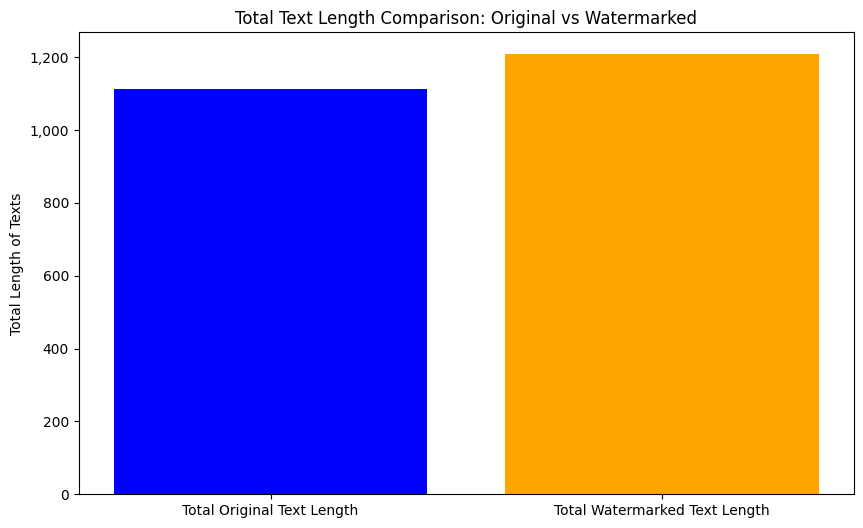

In [ ]:
# Sum the lengths of all original texts
total_original_length = submission_steganography_df['text'].apply(len).sum()

# Calculate the total length of all watermarked texts
total_watermarked_length = total_original_length + total_increase

# Prepare the data for plotting
totals = [total_original_length, total_watermarked_length]
labels = ['Total Original Text Length', 'Total Watermarked Text Length']

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, totals, color=['blue', 'orange'])

# Format the y-axis to show full numbers instead of scientific notation
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Total Text Length Comparison: Original vs Watermarked')
plt.ylabel('Total Length of Texts')
plt.show()